<a href="https://colab.research.google.com/github/guscldns/TestProject/blob/main/0703/0703_02_transfer_learning(ResNet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

In [ ]:
dir(tf.keras.applications)

['ConvNeXtBase',
 'ConvNeXtLarge',
 'ConvNeXtSmall',
 'ConvNeXtTiny',
 'ConvNeXtXLarge',
 'DenseNet121',
 'DenseNet169',
 'DenseNet201',
 'EfficientNetB0',
 'EfficientNetB1',
 'EfficientNetB2',
 'EfficientNetB3',
 'EfficientNetB4',
 'EfficientNetB5',
 'EfficientNetB6',
 'EfficientNetB7',
 'EfficientNetV2B0',
 'EfficientNetV2B1',
 'EfficientNetV2B2',
 'EfficientNetV2B3',
 'EfficientNetV2L',
 'EfficientNetV2M',
 'EfficientNetV2S',
 'InceptionResNetV2',
 'InceptionV3',
 'MobileNet',
 'MobileNetV2',
 'MobileNetV3Large',
 'MobileNetV3Small',
 'NASNetLarge',
 'NASNetMobile',
 'RegNetX002',
 'RegNetX004',
 'RegNetX006',
 'RegNetX008',
 'RegNetX016',
 'RegNetX032',
 'RegNetX040',
 'RegNetX064',
 'RegNetX080',
 'RegNetX120',
 'RegNetX160',
 'RegNetX320',
 'RegNetY002',
 'RegNetY004',
 'RegNetY006',
 'RegNetY008',
 'RegNetY016',
 'RegNetY032',
 'RegNetY040',
 'RegNetY064',
 'RegNetY080',
 'RegNetY120',
 'RegNetY160',
 'RegNetY320',
 'ResNet101',
 'ResNet101V2',
 'ResNet152',
 'ResNet152V2',
 'Re

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
from tensorflow.keras import datasets, layers, models

from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout, BatchNormalization

import matplotlib.pyplot as plt

In [ ]:
# 케라스 데이터셋을 다운받아 변수에 각각 넣어준다.
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


In [ ]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [ ]:
# 라벨 설정
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

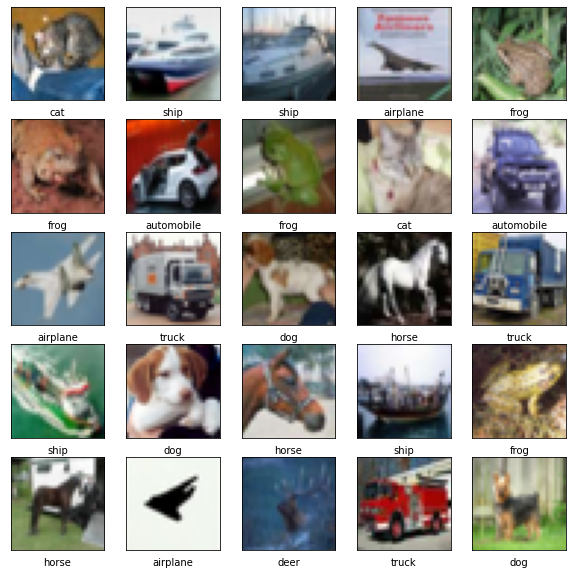

In [ ]:
# 이미지 불러보기
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[test_labels[i][0]])
plt.show()

## Pretrained model 그대로 사용

In [ ]:
model = ResNet50(include_top=True, input_shape = (224, 224 ,3), weights = 'imagenet')

102967424/102967424 [==============================] - 1s 0us/step


1) include_top = True, 분류기(완전연결계층) 여부  
2) weights = 'imagenet', 사전학습 weight 여부  
3) input_shape, Input 사이즈

In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',metrics = 'accuracy')

In [ ]:
# test_images = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)(test_images[:1000])
# test_images = tf.keras.applications.resnet50.preprocess_input(test_images)
resize = lambda x: tf.image.resize(x, (224, 224))
test_images = resize(test_images)
test_images.shape

TensorShape([10000, 224, 224, 3])

In [ ]:
model.evaluate(test_images, test_labels)

313/313 [==============================] - 39s 95ms/step - loss: 12.2576 - accuracy: 0.0000e+00


[12.257633209228516, 0.0]

## 전이학습 (transfer learning)

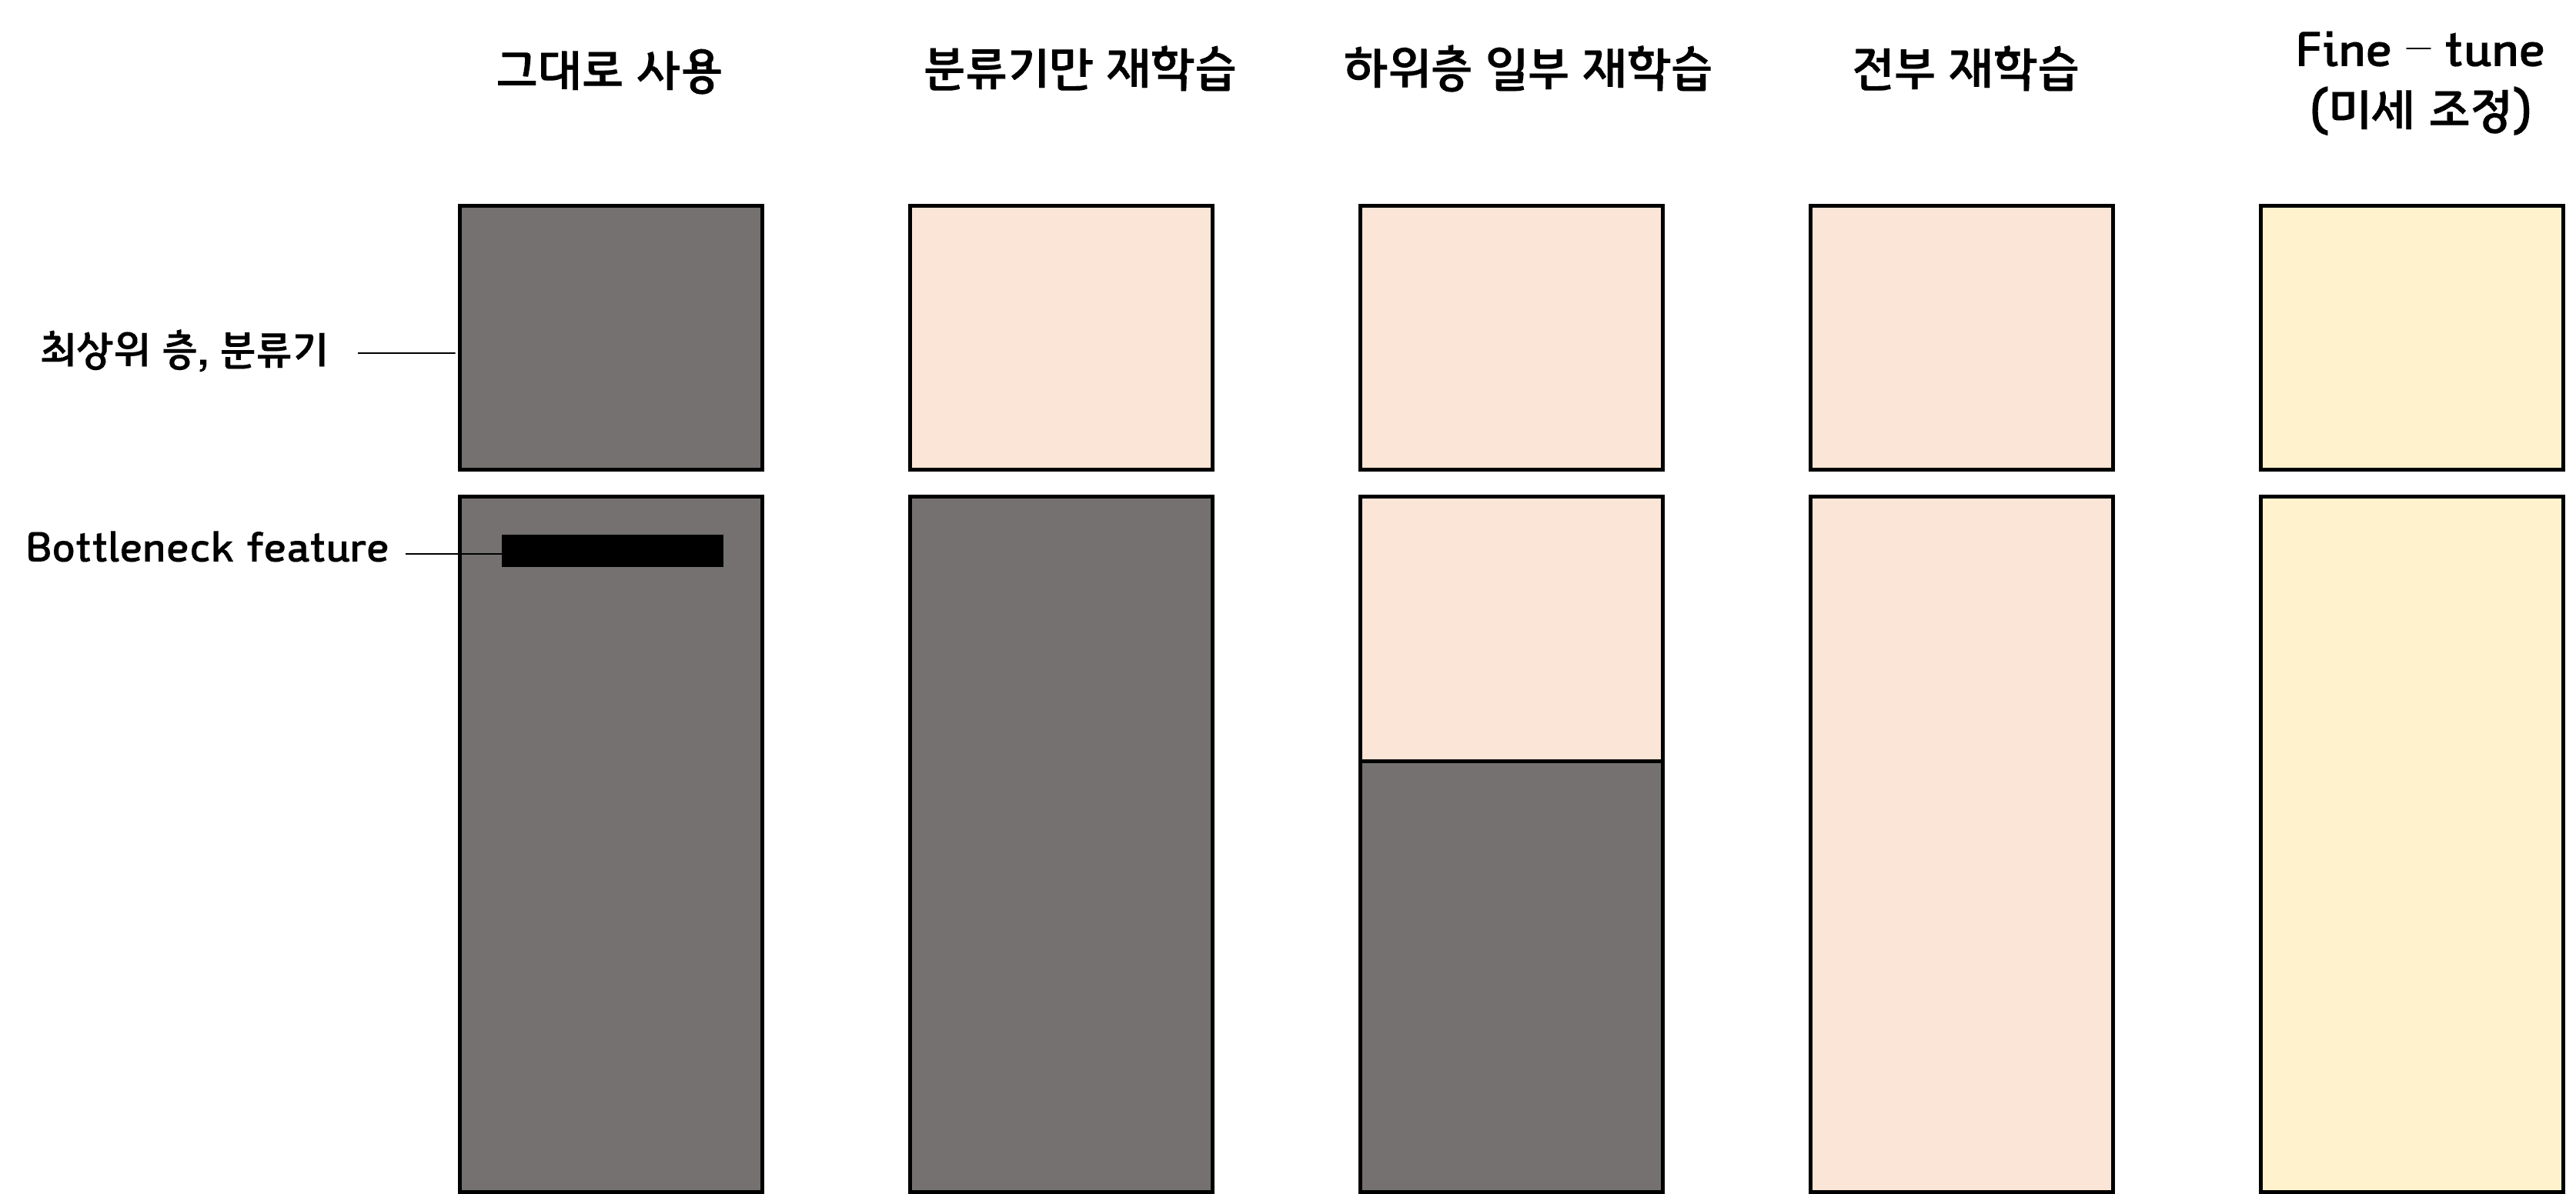

### 분류기부분만 재학습  

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [ ]:
base_model = ResNet50(include_top=False, input_shape = (32,32,3), weights = 'imagenet')

In [ ]:
base_model.output_shape

(None, 1, 1, 2048)

1) include_top = True, 분류기(완전연결계층) 여부  
2) weights = 'imagenet', 사전학습 weight 여부  
3) input_shape, Input 사이즈 (32, 32, 3)으로 변경

In [ ]:
base_model.trainable = False

In [ ]:
# sparse categorical crossentropy VS categorical crossentropy + one_hot
y_train = tf.keras.utils.to_categorical(train_labels, 10)
y_test = tf.keras.utils.to_categorical(test_labels, 10)
y_train.shape, y_test.shape

((50000, 10), (10000, 10))

In [ ]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [ ]:
# model.Sequential()없이 모델 구축하는 방법
inputs = tf.keras.Input(shape=(32, 32, 3))

x = base_model(inputs, training=False)
# training = False : batch_normalization은 업데이트 하지 않겠다, 업데이트 시 학습에 악영향을 줄 수 있다, 보통 False
x = tf.keras.layers.Flatten(input_shape=base_model.output_shape[1:])(x)
# output_shape[1:] : batch_size는 뺀다 (None, 1, 1, 2048) -> (1, 1, 2048)만 flatten 하겠다(batch_size는 펴주는데 영향을 미치지 않는다)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 24,114,826
Trainable params: 527,114
Non-traina

In [ ]:
# categorical_crossentropy
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001),
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

# 모델 fitting (분류층만 학습을 시키는 중)
model.fit(train_images, y_train, epochs = 5, validation_data=(test_images, y_test), batch_size=32)
# batch_size= 일반적으로 8의 배수로 주는 게 좋다
# 성능이 별로 안좋다 = 추측: 이미지 사이즈 224*224*3으로 학습했는데 32*32*3으로 해서 그런것이 아닐까
# 방법 1 이미지 리사이즈로 늘린다 : 이미지 사이즈를 늘리면 빈 공간이 생기는 데 그 공간에 보관법으로 숫자를 채운다(주변값 평균, 최대값 등으로 채운다), 퀄리티가 좋아지지는 않는다
# 방법 2 해상도를 늘린다 : 성능이 좋아질 가능성이 있다

Epoch 1/5
1563/1563 [==============================] - 31s 13ms/step - loss: 1.9153 - accuracy: 0.3912 - val_loss: 1.3231 - val_accuracy: 0.5399
Epoch 2/5
1563/1563 [==============================] - 18s 12ms/step - loss: 1.3905 - accuracy: 0.5147 - val_loss: 1.2079 - val_accuracy: 0.5794
Epoch 3/5
  48/1563 [..............................] - ETA: 15s - loss: 1.2666 - accuracy: 0.5605

### conv층 일부 재학습

In [ ]:
base_model = ResNet50(include_top=False, input_shape = (32,32 ,3), weights = 'imagenet')
# base_model.trainable = True : 전체 개방
# base_model의 일부 모델만 열고 싶은 경우 base_model에 어떤 레이어가 있는지 확인 필요

In [ ]:
len(base_model.layers)

175

In [ ]:
base_model.layers[:]
# 층 수에 해당하지 않는 레이어 다수 존재 (InputLayer, ZeroPadding2D 등)
# Conv2D 같은 층 수에 해당하는 레이어를 세야 한다

In [ ]:
base_model.trainable = False
base_model.trainable

False

In [ ]:
base_model.trainable =True
base_model.trainable

True

In [ ]:
for layer in base_model.layers[:-20]:
  layer.trainable = False

for layer in base_model.layers[-100:]:
  print(layer.name, layer.trainable)

conv3_block4_2_bn False
conv3_block4_2_relu False
conv3_block4_3_conv False
conv3_block4_3_bn False
conv3_block4_add False
conv3_block4_out False
conv4_block1_1_conv False
conv4_block1_1_bn False
conv4_block1_1_relu False
conv4_block1_2_conv False
conv4_block1_2_bn False
conv4_block1_2_relu False
conv4_block1_0_conv False
conv4_block1_3_conv False
conv4_block1_0_bn False
conv4_block1_3_bn False
conv4_block1_add False
conv4_block1_out False
conv4_block2_1_conv False
conv4_block2_1_bn False
conv4_block2_1_relu False
conv4_block2_2_conv False
conv4_block2_2_bn False
conv4_block2_2_relu False
conv4_block2_3_conv False
conv4_block2_3_bn False
conv4_block2_add False
conv4_block2_out False
conv4_block3_1_conv False
conv4_block3_1_bn False
conv4_block3_1_relu False
conv4_block3_2_conv False
conv4_block3_2_bn False
conv4_block3_2_relu False
conv4_block3_3_conv False
conv4_block3_3_bn False
conv4_block3_add False
conv4_block3_out False
conv4_block4_1_conv False
conv4_block4_1_bn False
conv4_bloc

In [ ]:
inputs = tf.keras.Input(shape=(32, 32, 3))

x = base_model(inputs, training=False) # batchnorm 부분 update 방지

x = tf.keras.layers.Flatten(input_shape=base_model.output_shape[1:])(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x= tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam( learning_rate= 0.0001),
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 24,114,826
Trainable params: 527,114
Non-trai

In [ ]:
model.fit(train_images, y_train, epochs = 5, validation_data=(test_images, y_test),
                   batch_size= 125)

Epoch 1/5
400/400 [==============================] - 9s 17ms/step - loss: 2.2917 - accuracy: 0.3362 - val_loss: 1.4344 - val_accuracy: 0.5018
Epoch 2/5
400/400 [==============================] - 6s 14ms/step - loss: 1.5411 - accuracy: 0.4638 - val_loss: 1.3056 - val_accuracy: 0.5453
Epoch 3/5
400/400 [==============================] - 6s 14ms/step - loss: 1.4014 - accuracy: 0.5092 - val_loss: 1.2390 - val_accuracy: 0.5721
Epoch 4/5
400/400 [==============================] - 6s 14ms/step - loss: 1.3087 - accuracy: 0.5417 - val_loss: 1.1931 - val_accuracy: 0.5842
Epoch 5/5
400/400 [==============================] - 6s 14ms/step - loss: 1.2484 - accuracy: 0.5634 - val_loss: 1.1641 - val_accuracy: 0.5932


### 전부 재학습

In [ ]:
# base_model 초기화
base_model = ResNet50(include_top=False, input_shape = (32,32 ,3), weights = 'imagenet')

In [ ]:
# 사전모델 전체 학습
base_model.trainable = True

for layer in base_model.layers[:]:
  print(layer.name, layer.trainable)

input_4 True
conv1_pad True
conv1_conv True
conv1_bn True
conv1_relu True
pool1_pad True
pool1_pool True
conv2_block1_1_conv True
conv2_block1_1_bn True
conv2_block1_1_relu True
conv2_block1_2_conv True
conv2_block1_2_bn True
conv2_block1_2_relu True
conv2_block1_0_conv True
conv2_block1_3_conv True
conv2_block1_0_bn True
conv2_block1_3_bn True
conv2_block1_add True
conv2_block1_out True
conv2_block2_1_conv True
conv2_block2_1_bn True
conv2_block2_1_relu True
conv2_block2_2_conv True
conv2_block2_2_bn True
conv2_block2_2_relu True
conv2_block2_3_conv True
conv2_block2_3_bn True
conv2_block2_add True
conv2_block2_out True
conv2_block3_1_conv True
conv2_block3_1_bn True
conv2_block3_1_relu True
conv2_block3_2_conv True
conv2_block3_2_bn True
conv2_block3_2_relu True
conv2_block3_3_conv True
conv2_block3_3_bn True
conv2_block3_add True
conv2_block3_out True
conv3_block1_1_conv True
conv3_block1_1_bn True
conv3_block1_1_relu True
conv3_block1_2_conv True
conv3_block1_2_bn True
conv3_block1

In [ ]:
inputs = tf.keras.Input(shape=(32, 32, 3))

x = base_model(inputs, training=False)

x = tf.keras.layers.Flatten(input_shape=model.output_shape[1:])(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x= tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001),
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                2570      
                                                                 
Total params: 24,114,826
Trainable params: 9,458,442
Non-tr

In [ ]:
model.trainable

True

In [ ]:
model.fit(train_images, y_train, epochs = 5, validation_data=(test_images, y_test),
                   batch_size= 125)

Epoch 1/5
400/400 [==============================] - 12s 21ms/step - loss: 1.6729 - accuracy: 0.4465 - val_loss: 1.1962 - val_accuracy: 0.5870
Epoch 2/5
400/400 [==============================] - 7s 18ms/step - loss: 1.2103 - accuracy: 0.5843 - val_loss: 1.0824 - val_accuracy: 0.6241
Epoch 3/5
400/400 [==============================] - 7s 18ms/step - loss: 1.0725 - accuracy: 0.6345 - val_loss: 1.0522 - val_accuracy: 0.6355
Epoch 4/5
400/400 [==============================] - 7s 19ms/step - loss: 0.9609 - accuracy: 0.6692 - val_loss: 1.0463 - val_accuracy: 0.6427
Epoch 5/5
400/400 [==============================] - 7s 18ms/step - loss: 0.8665 - accuracy: 0.7025 - val_loss: 1.0255 - val_accuracy: 0.6522


### 미세조정 (fine tune)

In [ ]:
## 일부 재학습 모델
base_model = ResNet50(include_top=False, input_shape = (32,32 ,3), weights = 'imagenet')

# base_model.trainable = False

# for layer in base_model.layers[-10:]:
#     layer.trainable = True

base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False


inputs = tf.keras.Input(shape=(32, 32, 3))

x = base_model(inputs, training=False) # batchnorm 부분 update 방지

x = tf.keras.layers.Flatten(input_shape=model.output_shape[1:])(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x= tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer = tf.keras.optimizers.Adam( learning_rate= 0.0001),
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
model.fit(train_images, y_train, epochs = 5, validation_data=(test_images, y_test),
                   batch_size= 125)

Epoch 1/5
400/400 [==============================] - 17s 26ms/step - loss: 1.7781 - accuracy: 0.4211 - val_loss: 1.2296 - val_accuracy: 0.5645
Epoch 2/5
400/400 [==============================] - 9s 22ms/step - loss: 1.2645 - accuracy: 0.5603 - val_loss: 1.1565 - val_accuracy: 0.5994
Epoch 3/5
400/400 [==============================] - 9s 22ms/step - loss: 1.1294 - accuracy: 0.6075 - val_loss: 1.0898 - val_accuracy: 0.6220
Epoch 4/5
400/400 [==============================] - 9s 22ms/step - loss: 1.0317 - accuracy: 0.6428 - val_loss: 1.0421 - val_accuracy: 0.6421
Epoch 5/5
400/400 [==============================] - 9s 22ms/step - loss: 0.9415 - accuracy: 0.6739 - val_loss: 1.0454 - val_accuracy: 0.6435


In [ ]:
## fine-tune
base_model.trainable = True

model.compile(optimizer = tf.keras.optimizers.Adam( learning_rate= 0.00001),
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])

model.fit(train_images, y_train, epochs = 5, validation_data=(test_images, y_test),
                   batch_size= 125)

Epoch 1/5
400/400 [==============================] - 104s 69ms/step - loss: 0.5411 - accuracy: 0.8096 - val_loss: 1.0527 - val_accuracy: 0.6842
Epoch 2/5
400/400 [==============================] - 27s 68ms/step - loss: 0.4007 - accuracy: 0.8608 - val_loss: 1.0991 - val_accuracy: 0.6912
Epoch 3/5
400/400 [==============================] - 27s 68ms/step - loss: 0.3092 - accuracy: 0.8909 - val_loss: 1.1320 - val_accuracy: 0.6963
Epoch 4/5
400/400 [==============================] - 27s 68ms/step - loss: 0.2381 - accuracy: 0.9169 - val_loss: 1.2507 - val_accuracy: 0.7003
Epoch 5/5
400/400 [==============================] - 27s 69ms/step - loss: 0.1799 - accuracy: 0.9383 - val_loss: 1.3105 - val_accuracy: 0.7029
